# Histogram matching algoritm with numpy

Pure numpy algorithm to adjust values of a **source** ndarray such that it's histogram 
matches that of a **reference** ndarray. The source and reference arrays can be any dimension
and may differ in shape. They should have the same dtype however.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
source2D = np.array([[10, 20, 40],
                   [20, 10, 60],
                   [40, 90, 10]])

reference2D = np.array([[ 25, 35, 63],
                      [63, 25, 90],
                      [63, 99, 10]])

Save the original shape for later to reconstruct

In [3]:
orig_shape = source2D.shape
orig_shape

(3, 3)

For the rest of the analysis, unravel into a 1D array

In [4]:
source = source2D.ravel()
print(source)
reference = reference2D.ravel()
print(reference)

[10 20 40 20 10 60 40 90 10]
[25 35 63 63 25 90 63 99 10]


Get the set of unique pixel values and their corresponding indices and counts

In [5]:
s_values, s_idx, s_counts = np.unique(
    source, return_inverse=True, return_counts=True)

print(s_values, s_idx, s_counts)

[10 20 40 60 90] [0 1 2 1 0 3 2 4 0] [3 2 2 1 1]


Let's look at what `s_values` and `s_counts` do. It's simply all unique values in the source and their corresponding counts. So you can see we have three 10s, two 20s, etc. 

In [6]:
print(tuple(zip(s_values, s_counts)))

((10, 3), (20, 2), (40, 2), (60, 1), (90, 1))


The `s_idx` contains indexes to look up values from `s_values` in order to reconstruct the original array.

In [7]:
# the original source array
np.array([s_values[idx] for idx in s_idx]).reshape(orig_shape)

array([[10, 20, 40],
       [20, 10, 60],
       [40, 90, 10]])

We can do the same with the reference (but we don't need the `r_idx` for this)

In [8]:
r_values, r_counts = np.unique(reference, return_counts=True)
print(r_values, r_counts)

[10 25 35 63 90 99] [1 2 1 3 1 1]


Now we need to calculate the empirical cumulative distribuition, scaled 0 to 1. Each `quantiles` tells us, for each unique `value`, what proportion of the data fall at or below that value.

In [9]:
s_quantiles = np.cumsum(s_counts).astype(np.float64) / source.size
tuple(zip(s_values, s_quantiles))

((10, 0.33333333333333331),
 (20, 0.55555555555555558),
 (40, 0.77777777777777779),
 (60, 0.88888888888888884),
 (90, 1.0))

In [10]:
r_quantiles = np.cumsum(r_counts).astype(np.float64) / reference.size
tuple(zip(r_values, r_quantiles))

((10, 0.1111111111111111),
 (25, 0.33333333333333331),
 (35, 0.44444444444444442),
 (63, 0.77777777777777779),
 (90, 0.88888888888888884),
 (99, 1.0))

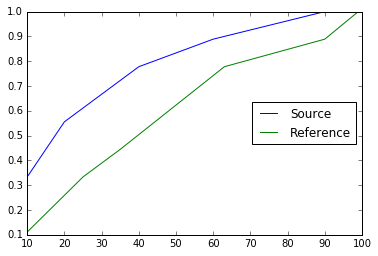

In [11]:
plt.plot(s_values, s_quantiles, label="Source")
plt.plot(r_values, r_quantiles, label="Reference")
plt.legend(loc=5)

To put it simplistically, we need to adjust `source` so that the blue line matches the green line as closely as possible.

To do this, we can linearly interpolate on the arrays. This is the **core concept** of the algorithm. The value of the source CDF at each unique input is mapped to the reference CDF (It need not be an exact equality as we use linear interpolation). The reference cdf value is then used to look up the corresponding reference value (interpolated between values if the match isn't exact).

The interpolated values have the same shape as `s_values` - the result is the new set of source values to replace the original. 

In [12]:
print(s_quantiles)
print(r_quantiles)
print(r_values)

interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)
interp_r_values

[ 0.33333333  0.55555556  0.77777778  0.88888889  1.        ]
[ 0.11111111  0.33333333  0.44444444  0.77777778  0.88888889  1.        ]
[10 25 35 63 90 99]


array([ 25.        ,  44.33333333,  63.        ,  90.        ,  99.        ])

In a way you could think of it as a lookup table mapping from source to target values, independent of it's position in the original array. e.g. `10` becomes `25.0`.

In [13]:
dict(zip(s_values, interp_r_values))

{10: 25.0, 20: 44.333333333333336, 40: 63.0, 60: 90.0, 90: 99.0}

Now we can take our `s_idx` to recreate an array of the same size as the source but with new values

In [14]:
target = interp_r_values[s_idx].reshape(orig_shape)
target

array([[ 25.        ,  44.33333333,  63.        ],
       [ 44.33333333,  25.        ,  90.        ],
       [ 63.        ,  99.        ,  25.        ]])

`target` has the same shape and *relative* spatial pattern as `source` but 
with values adjusted to match the histogram of `reference`. Let's look at them side-by-side.

In [15]:
print("Source\n", source2D.astype('uint8'))
print("Target\n", target.astype('uint8'))


Source
 [[10 20 40]
 [20 10 60]
 [40 90 10]]
Target
 [[25 44 63]
 [44 25 90]
 [63 99 25]]


We can also visually assess the quality of the histogram match

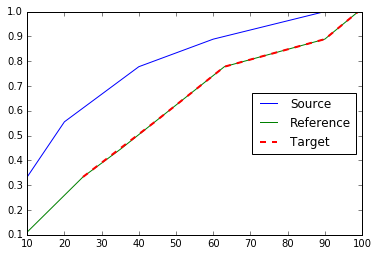

In [16]:
t_values, t_counts = np.unique(target, return_counts=True)
t_quantiles = np.cumsum(t_counts).astype(np.float64) / target.size

plt.plot(s_values, s_quantiles, label="Source")
plt.plot(r_values, r_quantiles, label="Reference")
plt.plot(t_values, t_quantiles, '--r', lw=2, label="Target")
plt.legend(loc=5)
